### 파생변수 & 수치형 스케일링 적용 후 모델링 재시도

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (에러 시 생략 가능)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# ✅ 1. 기본 모듈 로딩
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from modules.preprocess_cols import preprocess_telco_columns, add_derived_features, scale_numeric_features, calculate_vif_safe

# ✅ 2. 데이터 로딩 및 전처리
df_raw = pd.read_csv('../data/telco.csv')
df_proc = preprocess_telco_columns(df_raw)
df_proc = add_derived_features(df_proc)

# ✅ 3. 스케일링 적용 대상 수치형 변수 추출
numeric_cols = df_proc.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('Churn')  # 타겟 제외
df_proc = scale_numeric_features(df_proc, numeric_cols)

# ✅ 4. VIF 10 이상 컬럼 제거
vif_df = calculate_vif_safe(df_proc)
high_vif_cols = vif_df[vif_df["VIF"] > 10]["feature"].tolist()
high_vif_cols = [col for col in high_vif_cols if col != 'const']
df_proc_vif = df_proc.drop(columns=high_vif_cols)

# ✅ 5. 모델 학습 준비
X = df_proc_vif.drop(columns=["Churn"])
y = df_proc_vif["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ 6. XGBoost 모델 학습
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# ✅ 7. 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("📊 F1 Score:", f1_score(y_test, y_pred).round(4))
print("📈 AUC Score:", roc_auc_score(y_test, y_proba).round(4))
print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


c:\Users\somee\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


📊 F1 Score: 0.935
📈 AUC Score: 0.9919

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1035
           1       0.97      0.90      0.93       374

    accuracy                           0.97      1409
   macro avg       0.97      0.95      0.96      1409
weighted avg       0.97      0.97      0.97      1409

🧩 Confusion Matrix:
 [[1024   11]
 [  36  338]]


In [5]:
import pandas as pd
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, make_scorer

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 700),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "random_state": 42,
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(f1_score)).mean()
    return score

| 항목      | 설정                                                                                                                |
| ------- | ----------------------------------------------------------------------------------------------------------------- |
| 튜닝 기준   | F1 Score (cross\_val 기반)                                                                                          |
| 파라미터 범위 | `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `gamma`, `reg_alpha`, `reg_lambda` |
| 평가 방식   | 3-Fold Cross-Validation                                                                                           |

In [6]:
# ✅ Optuna 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-07-23 10:39:43,956] A new study created in memory with name: no-name-02fd549c-6f66-407c-9ab6-999cdb0fae86
[I 2025-07-23 10:39:46,701] Trial 0 finished with value: 0.9276787629130144 and parameters: {'n_estimators': 408, 'max_depth': 6, 'learning_rate': 0.09737650883193348, 'subsample': 0.7832030295160337, 'colsample_bytree': 0.619222602828633, 'gamma': 2.0070411916746336, 'reg_alpha': 0.7332147952422101, 'reg_lambda': 1.513138373583991}. Best is trial 0 with value: 0.9276787629130144.
[I 2025-07-23 10:39:51,065] Trial 1 finished with value: 0.9288792510117062 and parameters: {'n_estimators': 649, 'max_depth': 5, 'learning_rate': 0.2894411550749773, 'subsample': 0.975204477783852, 'colsample_bytree': 0.9011871452107918, 'gamma': 3.9239920109960487, 'reg_alpha': 0.5741632319324002, 'reg_lambda': 1.5685335288232816}. Best is trial 1 with value: 0.9288792510117062.
[I 2025-07-23 10:39:52,110] Trial 2 finished with value: 0.921189443747326 and parameters: {'n_estimators': 183, 'max_

In [7]:
# ✅ 최적 파라미터 출력
print("🎯 Best Trial:")
print(study.best_trial.params)

🎯 Best Trial:
{'n_estimators': 312, 'max_depth': 6, 'learning_rate': 0.01217317863630789, 'subsample': 0.5663443775994621, 'colsample_bytree': 0.7267490870673013, 'gamma': 1.7826571225623753, 'reg_alpha': 0.780401830817389, 'reg_lambda': 0.6431009914444871}


In [8]:
# ✅ 최적 모델 재학습 및 평가
best_model = XGBClassifier(**study.best_trial.params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7267490870673013, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.7826571225623753, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01217317863630789, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=312, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [9]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("📊 F1 Score:", f1_score(y_test, y_pred).round(4))
print("📈 AUC Score:", roc_auc_score(y_test, y_proba).round(4))

📊 F1 Score: 0.9265
📈 AUC Score: 0.9925


- 성능 미세 저하 확인 <- 기존 모델이 거의 최적이었을수도

In [40]:
import joblib

def save_model_with_assets(model, features, threshold, scaler, label_encoder, path='xgb_telco_bundle.pkl'):
    package = {
        'model': model,
        'features': features,
        'threshold': threshold,
        'scaler': scaler,
        'label_encoder': label_encoder
    }
    joblib.dump(package, path)

In [11]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import numpy as np

def objective(trial):
    # 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 2),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 2),
        "random_state": 42,
        "n_jobs": -1,
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)

    # Stratified K-Fold CV 기반 F1 score 평균
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        score = f1_score(y_valid, preds)
        f1_scores.append(score)

    return np.mean(f1_scores)

# Optuna 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적 파라미터 출력
print("Best Trial:", study.best_trial.params)

[I 2025-07-23 10:45:37,693] A new study created in memory with name: no-name-62e0875d-ef05-4925-bffe-00b487ae3fb2
[I 2025-07-23 10:45:47,693] Trial 0 finished with value: 0.9310038412756706 and parameters: {'n_estimators': 477, 'max_depth': 10, 'learning_rate': 0.14923920121203355, 'subsample': 0.7119058600701953, 'colsample_bytree': 0.9161796336874944, 'gamma': 4.116319107435816, 'reg_alpha': 0.6954196338123568, 'reg_lambda': 0.3375426257711187}. Best is trial 0 with value: 0.9310038412756706.
[I 2025-07-23 10:45:55,104] Trial 1 finished with value: 0.9277653176393746 and parameters: {'n_estimators': 466, 'max_depth': 7, 'learning_rate': 0.20113386855198484, 'subsample': 0.5175775366934765, 'colsample_bytree': 0.9364931972934476, 'gamma': 3.0487279165701677, 'reg_alpha': 1.2567598392506865, 'reg_lambda': 1.8783979633438943}. Best is trial 0 with value: 0.9310038412756706.
[I 2025-07-23 10:45:58,268] Trial 2 finished with value: 0.9310565039515705 and parameters: {'n_estimators': 388, 

Best Trial: {'n_estimators': 545, 'max_depth': 8, 'learning_rate': 0.0480177594000597, 'subsample': 0.9081168403005275, 'colsample_bytree': 0.7120620674637343, 'gamma': 3.6137984482317225, 'reg_alpha': 1.3020480072687963, 'reg_lambda': 0.2542404431569022}


In [14]:
# ✅ 6. 최적 파라미터 (Optuna 결과 기반)
best_params = {
    'n_estimators': 545,
    'max_depth': 8,
    'learning_rate': 0.0480177594000597,
    'subsample': 0.9081168403005275,
    'colsample_bytree': 0.7120620674637343,
    'gamma': 3.6137984482317225,
    'reg_alpha': 1.3020480072687963,
    'reg_lambda': 0.2542404431569022,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'logloss'
}

In [15]:
# ✅ 7. 모델 학습 (StratifiedKFold 5-Fold 기준)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_f1s, val_aucs = [], []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBClassifier(**best_params)
    model.fit(X_tr, y_tr)

    val_pred = model.predict(X_val)
    val_prob = model.predict_proba(X_val)[:, 1]

    val_f1s.append(f1_score(y_val, val_pred))
    val_aucs.append(roc_auc_score(y_val, val_prob))

print(f"✅ CV 평균 F1 Score: {sum(val_f1s)/len(val_f1s):.4f}")
print(f"✅ CV 평균 AUC Score: {sum(val_aucs)/len(val_aucs):.4f}")

# ✅ 8. 테스트셋 평가
final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print(f"📊 Test F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"📈 Test AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("📋 Classification Report:\n", classification_report(y_test, y_pred))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ CV 평균 F1 Score: 0.9313
✅ CV 평균 AUC Score: 0.9932
📊 Test F1 Score: 0.9313
📈 Test AUC Score: 0.9934
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1035
           1       0.96      0.91      0.93       374

    accuracy                           0.96      1409
   macro avg       0.96      0.95      0.95      1409
weighted avg       0.96      0.96      0.96      1409

📉 Confusion Matrix:
 [[1020   15]
 [  35  339]]


- 이탈고객 (1) 재현율 0.90 -> 0.91 로 소폭상승
- 전체 정확도 및 Score는 미세 하락

### Threashold 조정

In [16]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_prob):
    """
    다양한 threshold를 기준으로 F1 Score를 계산하고,
    가장 높은 F1을 갖는 최적 threshold를 반환
    """
    best_thr = 0.5
    best_f1 = 0

    for thr in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_prob >= thr).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    return best_thr, best_f1

In [36]:
# 1. 예측 확률 산출
y_proba = final_model.predict_proba(X_test)[:, 1]

# 2. 최적 threshold 탐색
best_thr, best_f1 = find_best_threshold(y_test, y_proba)
print(f"✅ Best Threshold for Tuned model: {best_thr:.2f}, F1 Score: {best_f1:.4f}")

✅ Best Threshold for Tuned model: 0.53, F1 Score: 0.9335


In [41]:
# 1. 예측 확률 산출
y_proba = model.predict_proba(X_test)[:, 1]

# 2. 최적 threshold 탐색
best_thr, best_f1 = find_best_threshold(y_test, y_proba)
print(f"✅ Best Threshold for Original model: {best_thr:.2f}, F1 Score: {best_f1:.4f}")

✅ Best Threshold for Original model: 0.37, F1 Score: 0.9351


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# 최적 threshold 기반 예측
y_pred_best = (y_proba >= best_thr).astype(int)

# 결과 확인
print("Original Model")
print("📋 Classification Report:\n", classification_report(y_test, y_pred_best))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Original Model
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1035
           1       0.95      0.93      0.94       374

    accuracy                           0.97      1409
   macro avg       0.96      0.95      0.96      1409
weighted avg       0.97      0.97      0.97      1409

🧩 Confusion Matrix:
 [[1015   20]
 [  28  346]]


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# 최적 threshold 기반 예측
y_pred_best = (y_proba >= best_thr).astype(int)

# 결과 확인
print("Tuned Model")
print("📋 Classification Report:\n", classification_report(y_test, y_pred_best))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Tuned Model
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1035
           1       0.97      0.90      0.93       374

    accuracy                           0.97      1409
   macro avg       0.97      0.95      0.96      1409
weighted avg       0.97      0.97      0.97      1409

🧩 Confusion Matrix:
 [[1024   11]
 [  37  337]]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from modules.preprocess_cols import preprocess_telco_columns, add_derived_features, scale_numeric_features, calculate_vif_safe, save_model_with_assets

In [4]:
# 1. 데이터 로드 및 전처리
df_raw = pd.read_csv('../00.data/telco.csv')
df_proc = preprocess_telco_columns(df_raw)
df_proc = add_derived_features(df_proc)

# ✅ 3. 스케일링 적용 대상 수치형 변수 추출
numeric_cols = df_proc.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('Churn')  # 타겟 제외
df_proc, scaler = scale_numeric_features(df_proc, numeric_cols)

# ✅ 4. VIF 10 이상 컬럼 제거
vif_df = calculate_vif_safe(df_proc)
high_vif_cols = vif_df[vif_df["VIF"] > 10]["feature"].tolist()
high_vif_cols = [col for col in high_vif_cols if col != 'const']
df_proc_vif = df_proc.drop(columns=high_vif_cols)

# 4. Train-Test 분리
X = df_proc_vif.drop(columns=["Churn"])
y = df_proc_vif["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ✅ 5. XGBoost 모델 학습
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 6. Threshold 최적화
from sklearn.metrics import precision_recall_curve

probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("🔍 Best Threshold:", round(best_threshold, 4))

# 7. 피처 저장
selected_features = list(X.columns)

# 8. 모델 + 전처리자 + 임계값 저장
save_model_with_assets(
    model=model,
    features=selected_features,
    threshold=best_threshold,
    scaler=scaler,
    #label_encoder=label_encoder
)

AttributeError: 'tuple' object has no attribute 'copy'

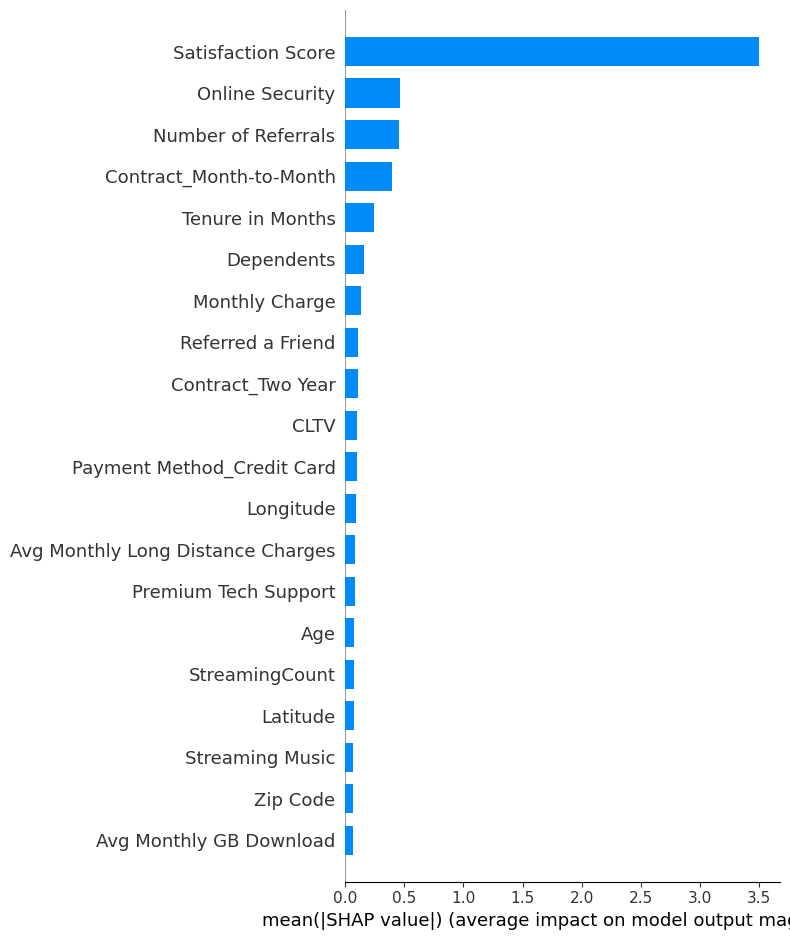

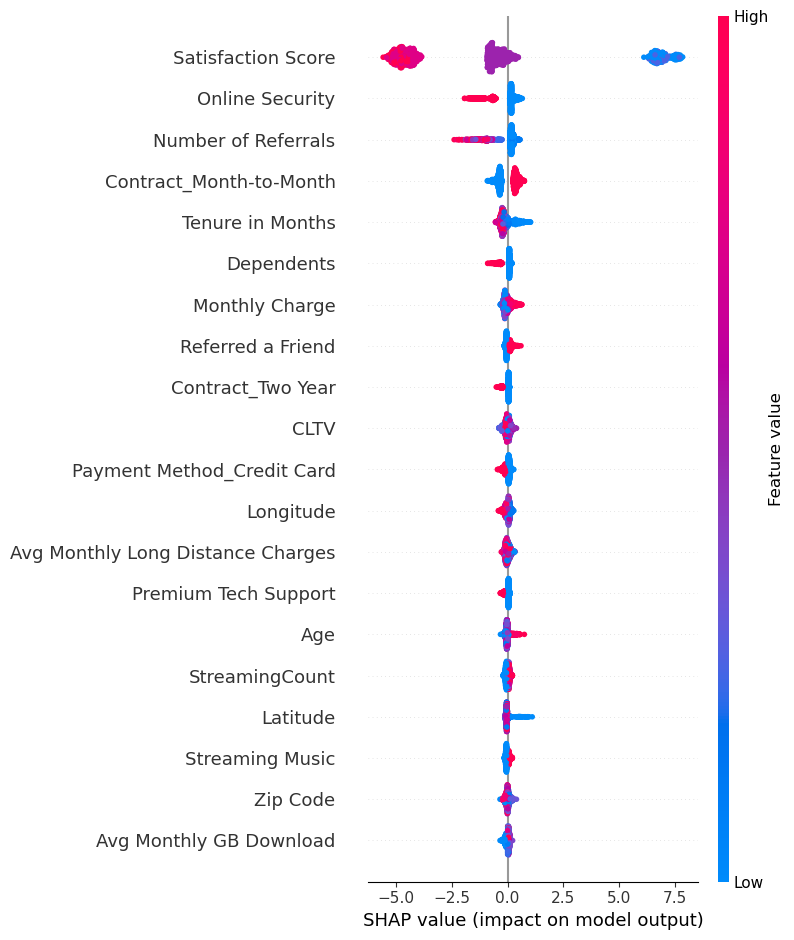

In [25]:
import shap
import matplotlib.pyplot as plt

# 1. SHAP explainer 초기화
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# 2. Summary Plot (전체 변수 중요도 + 영향 방향)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)  # dot plot

C:\Users\somee\AppData\Local\Temp\ipykernel_26220\2318592281.py:14: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_26220\2318592281.py:14: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_26220\2318592281.py:14: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51456 (\

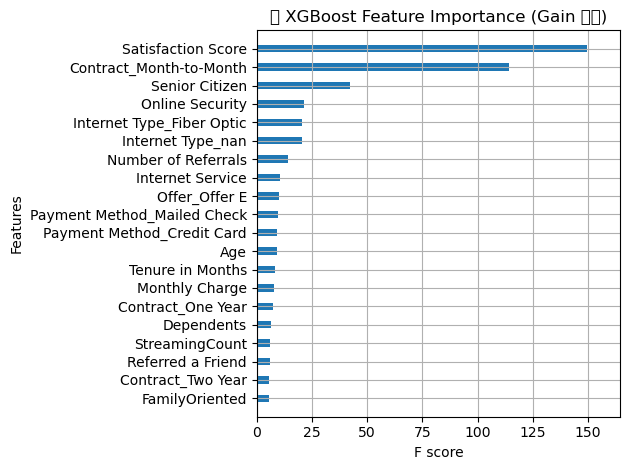

In [26]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# 상위 20개 변수만 표시 (gain 기준)
plot_importance(
    final_model,
    importance_type='gain',
    max_num_features=20,
    height=0.4,
    grid=True,
    show_values=False
)
plt.title("🧠 XGBoost Feature Importance (Gain 기준)")
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import pandas as pd

# SHAP 절댓값 평균 계산
shap_importance = np.abs(shap_values).mean(axis=0)

# 상위 20개 정렬
shap_summary = pd.Series(shap_importance, index=X_test.columns)
shap_top = shap_summary.sort_values(ascending=False).head(20)

print("📌 SHAP 기반 Feature 중요도 (평균 절댓값 기준)")
print(shap_top)

📌 SHAP 기반 Feature 중요도 (평균 절댓값 기준)
Satisfaction Score                   3.503069
Online Security                      0.460205
Number of Referrals                  0.455085
Contract_Month-to-Month              0.395901
Tenure in Months                     0.241374
Dependents                           0.162750
Monthly Charge                       0.132738
Referred a Friend                    0.107184
Contract_Two Year                    0.107119
CLTV                                 0.100626
Payment Method_Credit Card           0.099591
Longitude                            0.088180
Avg Monthly Long Distance Charges    0.080454
Premium Tech Support                 0.078723
Age                                  0.075101
StreamingCount                       0.073557
Latitude                             0.071809
Streaming Music                      0.069638
Zip Code                             0.069092
Avg Monthly GB Download              0.064237
dtype: float32


In [31]:
# XGBoost importance (Gain 기준)
xgb_gain = final_model.get_booster().get_score(importance_type='gain')
xgb_gain_series = pd.Series(xgb_gain).sort_values(ascending=False)

# 정렬 및 상위 20개
xgb_top = xgb_gain_series.head(20)

print("\n📌 XGBoost 기반 Feature 중요도 (Gain 기준)")
print(xgb_top)


📌 XGBoost 기반 Feature 중요도 (Gain 기준)
Satisfaction Score             149.543808
Contract_Month-to-Month        114.039146
Senior Citizen                  42.467545
Online Security                 21.643972
Internet Type_Fiber Optic       20.454470
Internet Type_nan               20.386747
Number of Referrals             14.050596
Internet Service                10.361236
Offer_Offer E                   10.021937
Payment Method_Mailed Check      9.866085
Payment Method_Credit Card       9.302197
Age                              9.290657
Tenure in Months                 8.509635
Monthly Charge                   7.915356
Contract_One Year                7.382420
Dependents                       6.640573
StreamingCount                   6.123981
Referred a Friend                5.869502
Contract_Two Year                5.780733
FamilyOriented                   5.606290
dtype: float64


In [32]:
# 공통 변수 기준 병합
importance_df = pd.DataFrame({
    'SHAP Importance': shap_top,
    'XGBoost Gain': xgb_top
}).fillna(0)

# 정렬
importance_df = importance_df.sort_values(by='SHAP Importance', ascending=False)

print("\n📊 SHAP vs XGBoost 중요도 비교표")
print(importance_df)


📊 SHAP vs XGBoost 중요도 비교표
                                   SHAP Importance  XGBoost Gain
Satisfaction Score                        3.503069    149.543808
Online Security                           0.460205     21.643972
Number of Referrals                       0.455085     14.050596
Contract_Month-to-Month                   0.395901    114.039146
Tenure in Months                          0.241374      8.509635
Dependents                                0.162750      6.640573
Monthly Charge                            0.132738      7.915356
Referred a Friend                         0.107184      5.869502
Contract_Two Year                         0.107119      5.780733
CLTV                                      0.100626      0.000000
Payment Method_Credit Card                0.099591      9.302197
Longitude                                 0.088180      0.000000
Avg Monthly Long Distance Charges         0.080454      0.000000
Premium Tech Support                      0.078723      0.00000